Step 1. Import libraries and set configs

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Colour_Palette = ['#01BEFE', '#FF7D00', '#FFDD00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(Colour_Palette))

Step 2. Load and view the data

In [ ]:
import yfinance as yf
from datetime import date

end_date = date.today().strftime("%Y-%m-%d")
start_date = '1990-01-01'

df = yf.download('AAPL', start=start_date, end=end_date)


print(df.head())
print('*'*100)
print(df.tail())
print('*'*100)
print(df.info())

[*********************100%***********************]  1 of 1 completed

Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
1990-01-02  0.262129  0.332589  0.334821  0.312500  0.314732  183198400
1990-01-03  0.263889  0.334821  0.339286  0.334821  0.339286  207995200
1990-01-04  0.264769  0.335938  0.345982  0.332589  0.341518  221513600
1990-01-05  0.265648  0.337054  0.341518  0.330357  0.337054  123312000
1990-01-08  0.267408  0.339286  0.339286  0.330357  0.334821  101572800
****************************************************************************************************
Price        Adj Close       Close        High         Low        Open  \
Ticker            AAPL        AAPL        AAPL        AAPL        AAPL   
Date                                                                     
2024-12-03  242.649994  242.649994  242.759995  238.899994  239.809998   
2024-12-04  243.009995  243

Step 3. Plot the data

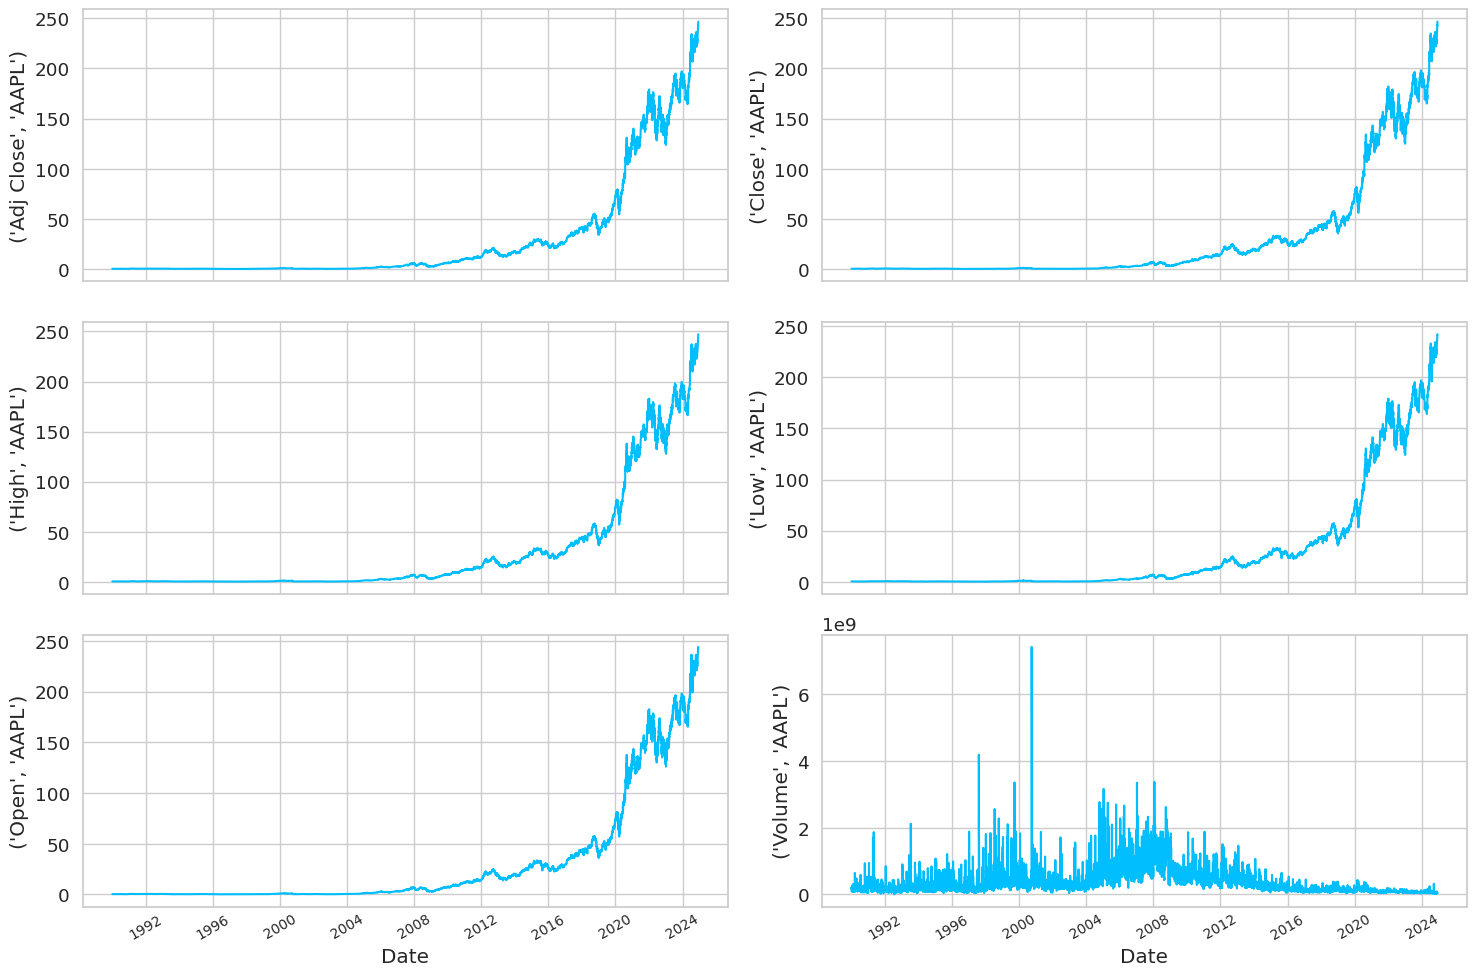

In [ ]:
import matplotlib.dates as mdates

def data_plot(df):
  df_plot = df.copy()
  n_col = 2
  n_row = int(round(df_plot.shape[1]/n_col, 0))
  fig, ax = plt.subplots(n_row, n_col, figsize = (15, 10), sharex = True)

  for i, ax in enumerate(fig.axes):
    sns.lineplot(data = df_plot.iloc[:,i], ax = ax)
    ax.tick_params(axis = "x", rotation = 30, labelsize=10, length = 0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
  fig.tight_layout()
  plt.show()

data_plot(df)

Step 4. Preprocess the data

In [ ]:
import math

training_data_len = math.ceil(len(df) * .8)
print(training_data_len)

train_data = df[:training_data_len].iloc[:, :1]
test_data = df[training_data_len:].iloc[:, :1]
print(train_data.shape, test_data.shape)

dataset_train = train_data.iloc[:, 0].values
dataset_train = np.reshape(dataset_train, (-1, 1))
print(dataset_train.shape)


dataset_test = test_data.iloc[:, 0].values
dataset_test = np.reshape(dataset_test, (-1, 1))
print(dataset_test.shape)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(dataset_train)


scaled_test = scaler.fit_transform(dataset_test)
print(scaled_train[:5])
print('*'*100)
print(scaled_test[:5])

7042
(7042, 1) (1760, 1)
(7042, 1)
(1760, 1)
[[0.00399587]
 [0.00403856]
 [0.00405992]
 [0.00408126]
 [0.00412394]]
****************************************************************************************************
[[0.03133609]
 [0.03026375]
 [0.0308939 ]
 [0.03083867]
 [0.0327733 ]]


Step 5. More data processing

In [ ]:
sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i + sequence_length])
    y_train.append(scaled_train[i + sequence_length])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

sequence_length = 30
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i + sequence_length])
    y_test.append(scaled_test[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([6992, 50, 1]) torch.Size([6992, 1])
torch.Size([1730, 30, 1]) torch.Size([1730, 1])


Step 6. Defind and train the LSTM neural network

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/50] - Training Loss: 0.0002, Test Loss: 0.0005
Epoch [20/50] - Training Loss: 0.0001, Test Loss: 0.0004
Epoch [30/50] - Training Loss: 0.0001, Test Loss: 0.0003
Epoch [40/50] - Training Loss: 0.0001, Test Loss: 0.0003
Epoch [50/50] - Training Loss: 0.0001, Test Loss: 0.0002


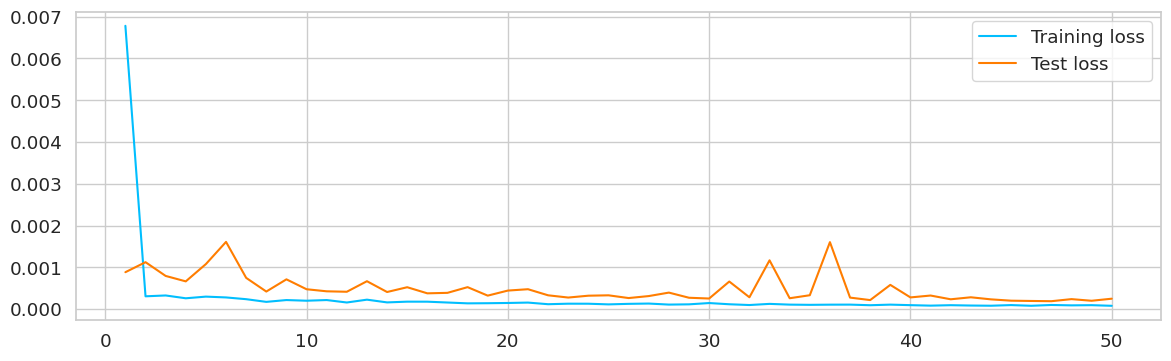

In [ ]:
from tqdm.notebook import tqdm

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out[:, -1, :])
        return out

device = 'cuda' if torch.cuda.is_available() else 'cpu'

input_size = 1
num_layers = 3
hidden_size = 128
output_size = 1
dropout = 0.2

model = LSTM(input_size, hidden_size, num_layers, dropout).to(device)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-3)

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50
train_hist = []
test_hist = []

for e in tqdm(range(num_epochs)):
    total_loss = 0
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (e + 1) % 10 == 0:
        print(f'Epoch [{e + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_hist,scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

Step 7. Forecast future values with model evaluation

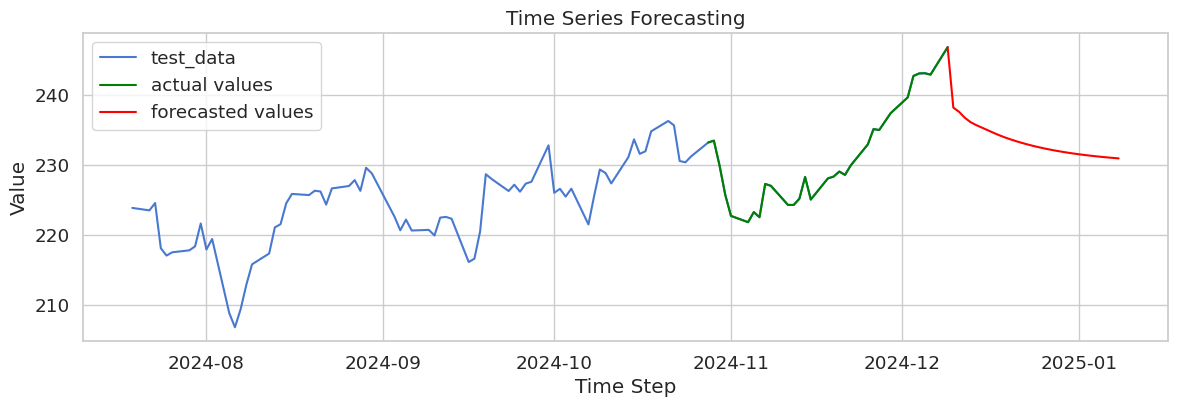

RMSE: 0.0153
R² Score: 0.9969


In [ ]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()
historical_data = sequence_to_plot[-1]

forecasted_values = []
with torch.no_grad():
    for _ in range(num_forecast_steps):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        forecasted_values.append(predicted_value)
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value

last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

plt.rcParams['figure.figsize'] = [14, 4]
plt.plot(test_data.index[-100:], test_data.iloc[-100:, 0], label="test_data", color="b")
plt.plot(test_data.index[-30:],test_data.iloc[-30:, 0], label='actual values', color='green')
plt.plot(test_data.index[-1:].append(future_dates), np.concatenate([test_data.iloc[-1:,0], scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten()]), label='forecasted values', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show()

model.eval()
with torch.no_grad():
    test_predictions = []
    for batch_X_test in X_test:
        batch_X_test = batch_X_test.to(device).unsqueeze(0)
        test_predictions.append(model(batch_X_test).cpu().numpy().flatten()[0])

test_predictions = np.array(test_predictions)

rmse = np.sqrt(mean_squared_error(y_test.cpu().numpy(), test_predictions))
r2 = r2_score(y_test.cpu().numpy(), test_predictions)

print(f'RMSE: {rmse:.4f}')
print(f'R² Score: {r2:.4f}')